In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## Load Data

In [2]:
calendar = pd.read_csv("calendar.txt", dtype={'start_date': str, 'end_date': str})
trips = pd.read_csv("trips.txt")
stop_times = pd.read_csv("stop_times.txt")
stops = pd.read_csv('stops.txt')

## Extract Charging Windows

In [3]:
def parse_time_to_minutes(t):
    h, m, s = map(int, t.split(':'))
    return h*60 + m + s/60

merged = stop_times.merge(trips[['trip_id', 'block_id']], on='trip_id', how='left')

merged = merged.merge(stops[['stop_id', 'stop_name']], on='stop_id', how='left')

merged['arrival_min'] = merged['arrival_time'].apply(parse_time_to_minutes)
merged['departure_min'] = merged['departure_time'].apply(parse_time_to_minutes)

grouped = merged.groupby(['block_id', 'trip_id'])
trip_summaries = grouped.agg(
    trip_start=('departure_min', 'min'),
    trip_end=('arrival_min', 'max'),
    stop_id=('stop_id', 'first'),
    stop_name=('stop_name', 'first')
).reset_index()

trip_summaries = trip_summaries.sort_values(by=['block_id', 'trip_start'])

trip_summaries['previous_trip_end'] = trip_summaries.groupby('block_id')['trip_end'].shift(1)
trip_summaries['gap'] = trip_summaries['trip_start'] - trip_summaries['previous_trip_end']
charging_windows = trip_summaries[trip_summaries['gap'] >= 5]

In [4]:
charging_windows.reset_index(drop=True, inplace=True)
charging_windows

,block_id,trip_id,trip_start,trip_end,stop_id,stop_name,previous_trip_end,gap
0,1001,t2DA-b3E9-slD,450.0,470.0,3588,The Shops at Ithaca Mall,445.0,5.0
1,1001,t33E-b3E9-slD,510.0,530.0,3588,The Shops at Ithaca Mall,505.0,5.0
2,1001,t3A2-b3E9-slD,570.0,590.0,3588,The Shops at Ithaca Mall,565.0,5.0
3,1001,t406-b3E9-slD,630.0,650.0,3588,The Shops at Ithaca Mall,625.0,5.0
4,1001,t7EE-b3E9-slD,1230.0,1250.0,3588,The Shops at Ithaca Mall,1225.0,5.0
...,...,...,...,...,...,...,...,...
534,3016,t672-bBC8-slF,1010.0,1039.0,165,Ithaca Commons - Green St,1000.0,10.0
535,3016,t6BD-bBC8-slF,1045.0,1070.0,2671,Compass MHC,1039.0,6.0
536,3016,t6DB-bBC8-slF,1075.0,1134.0,165,Ithaca Commons - Green St,1070.0,5.0
537,3017,t73A-bBC9-slF,1130.0,1153.0,165,Ithaca Commons - Green St,1124.0,6.0


In [5]:
output_df = pd.DataFrame(charging_windows)
             
output_df.to_csv("WS_charging_windows.csv", index=False)

## Plot Charging Windows

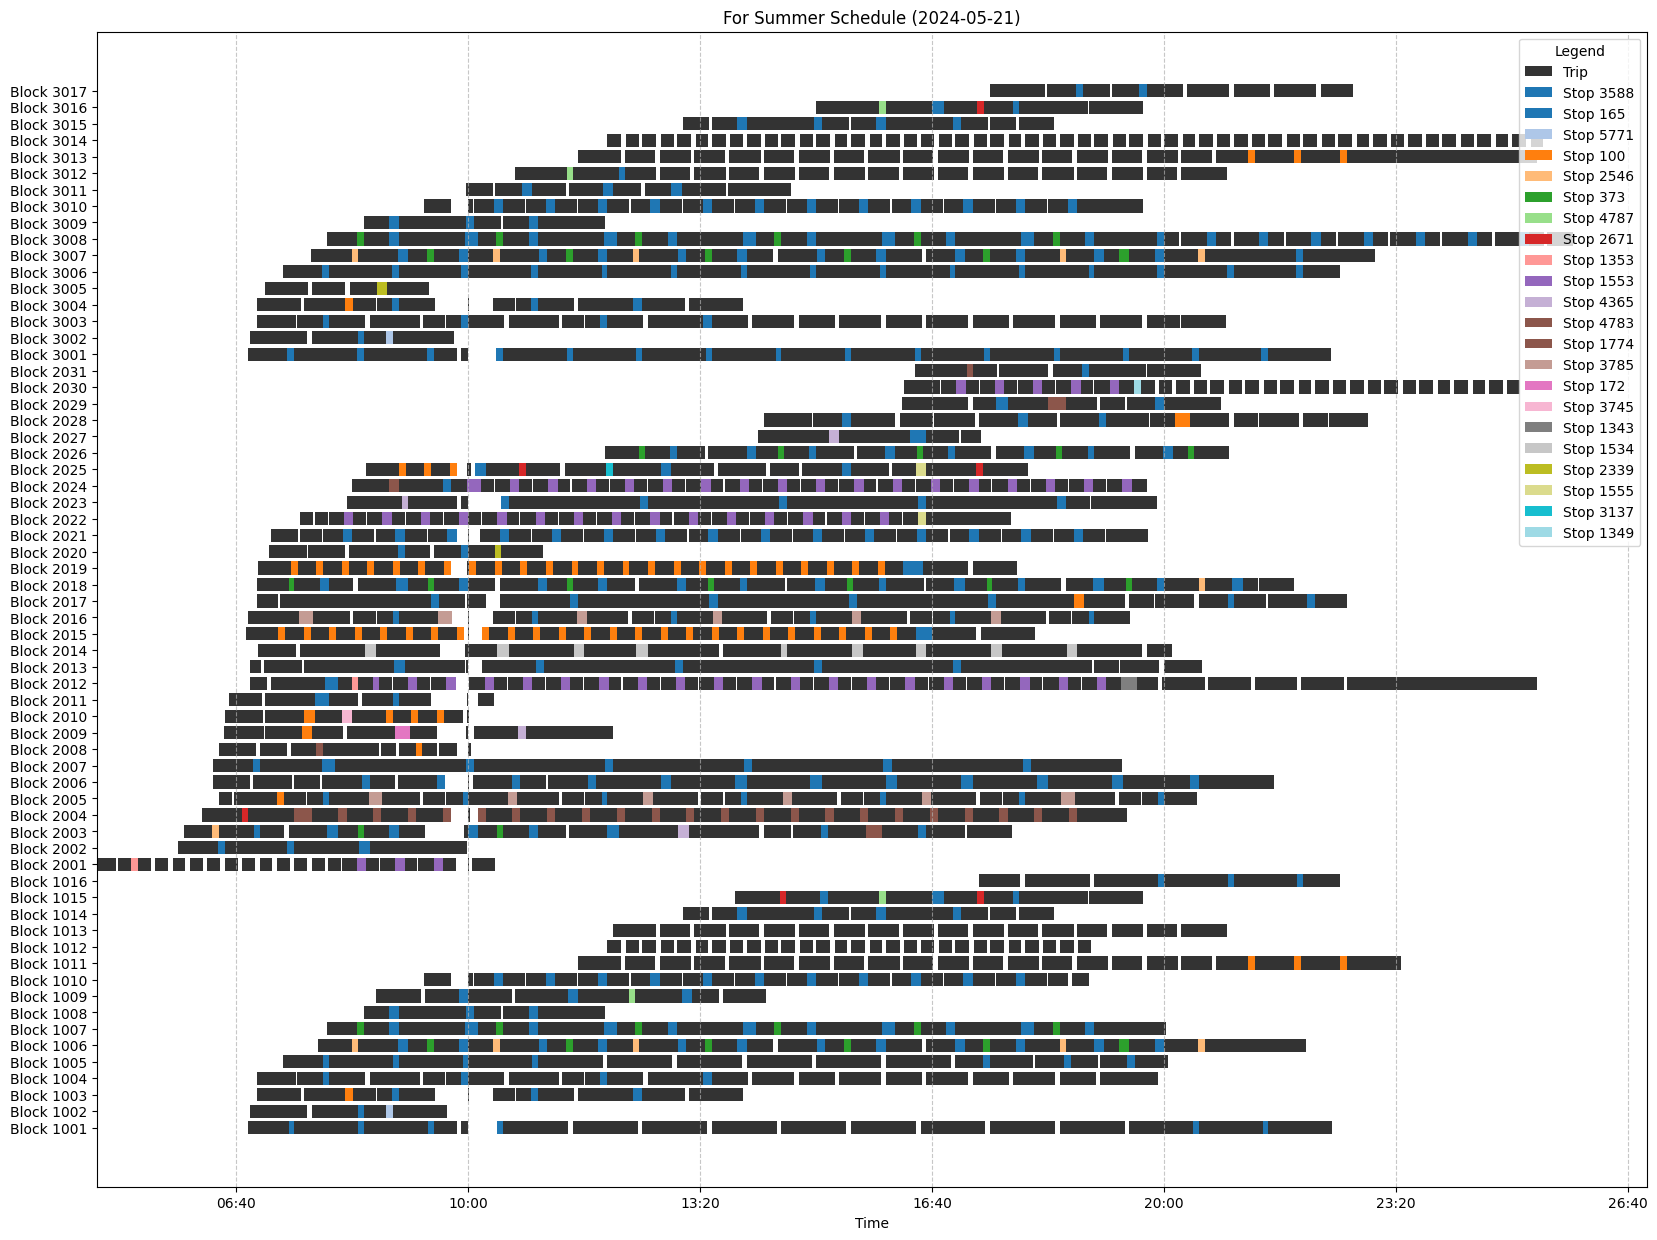

In [7]:
def minutes_to_time(x, pos):
    hours = int(x // 60)
    mins = int(x % 60)
    return f"{hours:02d}:{mins:02d}"

# Convert time to minutes for easier plotting
def time_to_minutes(time_str):
    h, m, s = map(int, time_str.split(":"))
    return h * 60 + m + s / 60

# Extract start and end times for each trip
trip_times = stop_times.groupby("trip_id").agg(
    trip_start=("departure_time", "min"),
    trip_end=("arrival_time", "max")
).reset_index()

# Convert times to minutes
trip_times["trip_start"] = trip_times["trip_start"].apply(time_to_minutes)
trip_times["trip_end"] = trip_times["trip_end"].apply(time_to_minutes)
trip_times["trip_duration"] = trip_times["trip_end"] - trip_times["trip_start"]

# Merge with trips to get block_id (bus assignment)
full_trip_info = pd.merge(trip_times, trips[["trip_id", "block_id"]], on="trip_id")

# Load existing charging windows dataset
df = charging_windows.copy()
df["stop_id"] = df["stop_id"].astype(str)

# Unique colors for each stop_id
unique_stops = df["stop_id"].unique()
color_map = {stop: plt.cm.tab20(i / len(unique_stops)) for i, stop in enumerate(unique_stops)}

# Map bus positions
bus_positions = {bus: i for i, bus in enumerate(sorted(full_trip_info["block_id"].unique()))}

# Plotting
fig, ax = plt.subplots(figsize=(20, 15))

# Plot all trips as black bars
for _, row in full_trip_info.iterrows():
    y_pos = bus_positions[row["block_id"]]
    ax.barh(
        y_pos,
        row["trip_duration"],
        left=row["trip_start"],
        color="black",
        alpha=0.8,
        label="Trip" if "Trip" not in locals() else ""
    )

# Plot charging windows from charging_windows dataset
for _, row in df.iterrows():
    y_pos = bus_positions[row["block_id"]]
    stop_color = color_map.get(row["stop_id"], "gray")

    # Charging window bar
    ax.barh(
        y_pos,
        row["gap"],
        left=row["previous_trip_end"],
        color=stop_color,
        alpha=1.0,
        label=f"Stop {row['stop_id']}" if row["stop_id"] not in locals() else ""
    )

# Format y-axis with bus IDs
ax.set_yticks(list(bus_positions.values()))
ax.set_yticklabels([f"Block {bus}" for bus in bus_positions.keys()])

# Format x-axis with time
ax.xaxis.set_major_formatter(mticker.FuncFormatter(minutes_to_time))

# Plot labels
ax.set_xlabel("Time")
ax.set_title("For Summer Schedule (2024-05-21)")

# Create legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title="Legend", loc="upper right")

# Display plot
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


## Make Input File

In [8]:
# Helpers
def time_to_minutes(t):
    if pd.isna(t):
        return np.nan
    if isinstance(t, (int, float, np.integer, np.floating)):
        return float(t)
    h, m, s = map(int, str(t).strip().split(":"))
    return h * 60 + m + s / 60.0

charging_windows = charging_windows.copy()

# Coerce dtypes
stop_times = stop_times.dropna(subset=["shape_dist_traveled"]).copy()
stop_times["shape_dist_traveled"] = pd.to_numeric(
    stop_times["shape_dist_traveled"], errors="coerce"
)
stop_times = stop_times.dropna(subset=["shape_dist_traveled"])
stop_times["arrival_time"]   = stop_times["arrival_time"].apply(time_to_minutes)
stop_times["departure_time"] = stop_times["departure_time"].apply(time_to_minutes)

if "block_id" in trips.columns:
    trips = trips.copy()
    trips["block_id"] = pd.to_numeric(trips["block_id"], errors="coerce")

for col in ["previous_trip_end", "trip_start", "trip_end", "gap"]:
    if col in charging_windows.columns:
        charging_windows[col] = pd.to_numeric(charging_windows[col], errors="coerce")

# Trip distances & times
trip_details = (
    stop_times
    .groupby("trip_id", as_index=False)
    .agg(
        trip_start=("departure_time", "min"),
        trip_end=("arrival_time",   "max"),
        start_mileage=("shape_dist_traveled", "min"),
        end_mileage=("shape_dist_traveled",   "max"),
    )
)

# feet to km
trip_details["trip_mileage"] = (
    trip_details["end_mileage"] - trip_details["start_mileage"]
) * 0.0003048

# Merge on block_id
cols_to_merge = [c for c in ["trip_id", "block_id"] if c in trips.columns]
trip_info = pd.merge(trip_details, trips[cols_to_merge], on="trip_id", how="left")
trip_info = trip_info[pd.notna(trip_info["block_id"])].copy()
trip_info["block_id"] = pd.to_numeric(trip_info["block_id"], errors="coerce")

# Sanity
assert pd.api.types.is_numeric_dtype(trip_info["trip_start"])
assert pd.api.types.is_numeric_dtype(trip_info["trip_end"])
assert pd.api.types.is_numeric_dtype(trip_info["trip_mileage"])
assert pd.api.types.is_numeric_dtype(charging_windows["previous_trip_end"])
assert pd.api.types.is_numeric_dtype(charging_windows["trip_start"])

# Build charging-windows input
output = []

for bus_id, group in charging_windows.groupby("block_id"):
    g  = group.sort_values(by="previous_trip_end").reset_index(drop=True)

    # trips for this block
    tf = trip_info[trip_info["block_id"] == bus_id].copy()

    # sort by start time
    tf = tf.sort_values("trip_start")

    # remove overlapping trips within this block
    # keep only a sequence where each trip starts at/after the previous kept trip ends
    keep_idx = []
    last_end = -np.inf
    for idx, trow in tf.iterrows():
        ts = trow["trip_start"]
        te = trow["trip_end"]
        if pd.isna(ts) or pd.isna(te):
            continue
        if ts >= last_end:
            keep_idx.append(idx)
            last_end = te
    
    tf = tf.loc[keep_idx].reset_index(drop=True)

    # de-dup within block by START TIME
    tf = tf.drop_duplicates(subset=["trip_start"], keep="first")

    # initial cumulative mileage = trips BEFORE the first window
    if len(g) > 0:
        first_window_start = g.loc[0, "previous_trip_end"]
        pre_mask = (tf["trip_end"] <= first_window_start)
        pre_trips = (
            tf.loc[pre_mask]
              .sort_values("trip_start")
              .drop_duplicates(subset=["trip_start"], keep="first")
        )
        cumulative_mileage = float(pre_trips["trip_mileage"].sum())
    else:
        cumulative_mileage = 0.0  # no windows for this block

    charging_window_id = 0

    for i, row in g.iterrows():
        # define the end of this window as the start of the next window;
        # for last window, go to last trip_end
        if i < len(g) - 1:
            next_window_start = g.loc[i + 1, "previous_trip_end"]
            mask = (
                (tf["trip_start"] >= row["previous_trip_end"]) &
                (tf["trip_end"]   <= next_window_start)
            )
        else:
            mask = (tf["trip_start"] >= row["previous_trip_end"])

        next_trips = (
            tf.loc[mask]
              .sort_values("trip_start")
              .drop_duplicates(subset=["trip_start"], keep="first")
        )
        next_trip_mileage = float(next_trips["trip_mileage"].sum())

        # skip windows with zero next-trip mileage
        if next_trip_mileage <= 0:
            continue

        output.append({
            "block_id": bus_id,
            "charging_window_id": charging_window_id,
            "start_time": row["previous_trip_end"],  
            "end_time": row["trip_start"],           
            "charging_time": row.get("gap", np.nan),
            "cumulative_mileage": cumulative_mileage,
            "next_trip_mileage": next_trip_mileage,
            "coef": 0.015,
            "pkk+1": 1.15,
            "power_per_SOC": 5,
            "stop_id": row["stop_id"],
        })

        cumulative_mileage += next_trip_mileage
        charging_window_id += 1


output_df = pd.DataFrame(output).sort_values(["block_id", "charging_window_id"])
print(output_df.head())

   block_id  charging_window_id  start_time  end_time  charging_time  \
0      1001                   0       445.0     450.0            5.0   
1      1001                   1       505.0     510.0            5.0   
2      1001                   2       565.0     570.0            5.0   
3      1001                   3       625.0     630.0            5.0   
4      1001                   4      1225.0    1230.0            5.0   

   cumulative_mileage  next_trip_mileage   coef  pkk+1  power_per_SOC  stop_id  
0           11.771567          18.086407  0.015   1.15              5     3588  
1           29.857973          18.086407  0.015   1.15              5     3588  
2           47.944380          18.086407  0.015   1.15              5     3588  
3           66.030787         180.864069  0.015   1.15              5     3588  
4          246.894856          18.086407  0.015   1.15              5     3588  


In [9]:
bad_blocks = (
    output_df.loc[output_df["next_trip_mileage"] > 60, "block_id"]
             .unique()
)
#print("Blocks removed:", bad_blocks)

output_df= output_df[~output_df["block_id"].isin(bad_blocks)].copy()
#print(output_df.head())

In [11]:
df = output_df.copy()
 
mileage_add_ft = df["next_trip_mileage"]           

out = pd.DataFrame({
    "v_num_id":        df["block_id"].astype(int),           
    "ki":              df["charging_window_id"].astype(int), 
    "start_time":      df["start_time"],                      
    "end_time":        df["end_time"],                        
    "charge_time":     df["charging_time"],                   
    "mileage_add":     mileage_add_ft,                       
    "coef":            df["coef"],                            
    "pkk+1":           df["pkk+1"],                           
    "power_per_SOC":   df["power_per_SOC"],                  
    "station_id":      df["stop_id"].astype(int),             
    "start_soc":       70,                                    
})


out = out.sort_values(["v_num_id", "ki"]).reset_index(drop=True)

out.to_csv("WS_input.csv", index=False)

print(out.head(15))

    v_num_id  ki  start_time  end_time  charge_time  mileage_add   coef  \
0       1002   0       505.0     510.0          5.0    19.893485  0.015   
1       1002   1       529.0     535.0          6.0    27.595589  0.015   
2       1003   0       494.0     501.0          7.0     7.226397  0.015   
3       1003   1       534.0     540.0          6.0    39.573011  0.015   
4       1003   2       654.0     660.0          6.0    33.311314  0.015   
5       1003   3       742.0     750.0          8.0    53.080082  0.015   
6       1006   0       500.0     505.0          5.0    10.688361  0.015   
7       1006   1       539.0     548.0          9.0     5.432842  0.015   
8       1006   2       564.0     570.0          6.0     6.803711  0.015   
9       1006   3       592.0     600.0          8.0     9.211637  0.015   
10      1006   4       621.0     627.0          6.0    10.688361  0.015   
11      1006   5       661.0     668.0          7.0     5.432842  0.015   
12      1006   6       68